In [1]:
import collections
import csv
import itertools
import json
import pickle
import operator
import os
import sklearn
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KernelDensity
import transformers
from matplotlib.patches import Rectangle

from rouge_score import rouge_scorer

## Load dataset

In [2]:
# Load the dataset
dataset_dir = '../data/N2C2-Track3-May3_rowid/'
df_train = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))
df_dev = pd.read_csv(os.path.join(dataset_dir, 'dev.csv'))
df_test = pd.read_csv(os.path.join('../data/N2C2-Track3-May3/', 'test.csv'))

In [3]:
df_train.head()

,ROW ID,HADM ID,SUBJECT ID,Assessment,Plan Subsection,Relation
0,701531,186454,40514,"51 yr old F with a history of 3V CAD, confirme...",# CORONARIES: Patient with 3 vessel disease on...,Direct
1,701531,186454,40514,"51 yr old F with a history of 3V CAD, confirme...",# Acute on Chronic systolic CHF: Patient with ...,Indirect
2,701531,186454,40514,"51 yr old F with a history of 3V CAD, confirme...",# Social stressors: Recently lost mother to ca...,Neither
3,701531,186454,40514,"51 yr old F with a history of 3V CAD, confirme...","# FEN: Replete lytes PRN, NPO for CABG today\n...",Not Relevant
4,554204,196435,85490,"CHRONIC OBSTRUCTIVE PULMONARY DISEASE (COPD, B...",# Dyspnea: Differential in this patient would ...,Direct


In [4]:
_relation_labels = {'Direct': 0, 'Indirect': 1, 'Neither': 2, 'Not Relevant': 3}
relations, labels = list(zip(*_relation_labels.items()))
relation_to_label = _relation_labels
label_to_relation = {l: r for r, l in relation_to_label.items()}

In [5]:
train_labels = np.array(df_train['Relation'].map(relation_to_label).tolist())
dev_labels = np.array(df_dev['Relation'].map(relation_to_label).tolist())

## Load a model prediction

In [6]:
def load_results(results_dir, ckpt_step=9999):
    with open(os.path.join(results_dir, f'results_train_{ckpt_step}.pkl'), 'rb') as fd:
        train_results = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
        dev_results = pickle.load(fd)
    with open(os.path.join(results_dir, f'results_test_{ckpt_step}.pkl'), 'rb') as fd:
        test_results = pickle.load(fd)
    return train_results, dev_results, test_results

def confusion_matrix_strs(y_true, y_pred, dataset=''):
    conf_mat = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    results = []
    results.append(f'{dataset.upper():<9}' + ' '.join([f'{r[:8]:>8}' for r in relations]) + '  Lbl cnt')
    for i in range(4):
        results.append(f'{relations[i][:8]:>8} ' + ' '.join([f'{c:8}' for c in conf_mat[i]]) + f' {sum(conf_mat[i]):8}')    
    results.append(f'Pred cnt ' + ' '.join([f'{sum(conf_mat[:,i]):8}' for i in range(4)]) + f' {np.sum(conf_mat):8}')    
    return results

def compute_acc_f1(preds, labels):
    corrects = preds == labels
    acc = np.mean(corrects)
    f1 = sklearn.metrics.f1_score(y_true=labels, y_pred=preds, average="macro")
    return acc, f1

def plot_print_results(train_preds, dev_preds, train_labels=train_labels, dev_labels=dev_labels):
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Train prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))
    ax = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true=dev_labels, y_pred=dev_preds, normalize='true', cmap=plt.cm.Blues, ax=ax)
    plt.title('Dev prediction'); plt.xticks(*zip(*label_to_relation.items())); plt.yticks(*zip(*label_to_relation.items()))

    train_correct = train_labels == train_preds
    dev_correct = dev_labels == dev_preds
    print(f'- Train set performance')
    print(f'    - Accuracy: {np.mean(train_correct):.6f} ({sum(train_correct)}/{len(train_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=train_labels, y_pred=train_preds, average="macro"):.6f}')
    print(f'- Dev set performance')
    print(f'    - Accuracy: {np.mean(dev_correct):.6f} ({sum(dev_correct)}/{len(dev_correct)})')
    print(f'    - Macro F1: {sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"):.6f}')
    
    train_conf_strs = confusion_matrix_strs(train_labels, train_preds, 'train')
    dev_conf_strs = confusion_matrix_strs(dev_labels, dev_preds, 'dev')
    for str1, str2 in zip(train_conf_strs, dev_conf_strs):
        print(str1 + ' | ' + str2)
        
def softmax(logits):
    logits = np.array(logits)
    logits -= (np.max(logits, axis=1, keepdims=True) - np.min(logits, axis=1, keepdims=True)) / 2
    exps = np.exp(logits)
    return exps / np.sum(exps, axis=1, keepdims=True)

In [7]:
def get_ensemble(dir_step_list, split='train', ensemble='logits'):
    logitss = []
    for results_dir, ckpt_step in dir_step_list:
        with open(os.path.join(results_dir, f'results_{split}_{ckpt_step}.pkl'), 'rb') as fd:
            results = pickle.load(fd)
        logitss.append(np.array([r['logits'] for r in results]))
        
    if ensemble == "logits":
        values = np.array(logitss).mean(axis=0)
    elif ensemble == "probs":
        values = np.array([softmax(logits) for logits in logitss]).mean(axis=0)
    else:
        raise ValueError(f"Wrong emsenble value: {ensemble}") 
    return values
    
def plot_results_ensemble(dir_step_list, ensemble="logits"):
    print('Ensemble of following results')    
    for results_dir, ckpt_step in dir_step_list:
        print(f'\t({results_dir}, step {ckpt_step})')  
        
    train_values = get_ensemble(dir_step_list, split='train', ensemble=ensemble)
    dev_values = get_ensemble(dir_step_list, split='dev', ensemble=ensemble)
    
    train_preds = np.argmax(train_values, axis=1)
    dev_preds = np.argmax(dev_values, axis=1)
    plot_confusion_matrix_traindev(train_preds, dev_preds)   

## Best single model


In [8]:
# Best single model
train_results, dev_results, test_results = load_results('../results/sent_rel_PubMedBERT_2gpu_noshuffle/', 4000)
train_logits = np.array([r['logits'] for r in train_results])
dev_logits = np.array([r['logits'] for r in dev_results])
test_logits = np.array([r['logits'] for r in test_results])
train_probs = softmax(train_logits)
dev_probs = softmax(dev_logits)
test_probs = softmax(test_logits)
train_preds = np.argmax(train_logits, axis=1)
dev_preds = np.argmax(dev_logits, axis=1)
test_preds = np.argmax(test_logits, axis=1)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.792295 (473/597)
    - Macro F1: 0.810949
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       29        2      179
 Neither        0        2     1482        0     1484 |  Neither        2       38      132        1      173
Not Rele        0        0        0      810      810 | Not Rele        4        2        3       91      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      132      200      170       95      597


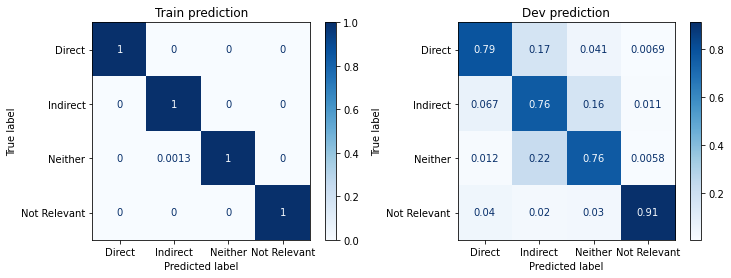

In [9]:
plot_print_results(train_preds, dev_preds)

In [10]:
def get_test_prediction_df(test_preds):
    assert len(test_preds) == len(df_test)
    df_test2 = df_test.copy()
    df_test2['Relation'] = [label_to_relation[l] for l in test_preds]
    return df_test2

test_output_dir = '../test_output/'

- Save test prediction

In [199]:
results_dir = '../results/sent_rel_PubMedBERT_2gpu_noshuffle/'
ckpt_step = 4000
test_output_fname = 'test_output_PubMedBERT_2gpu_noshuffle_train_4000.csv'
_, _, test_results = load_results(results_dir, ckpt_step)
test_logits = np.array([r['logits'] for r in test_results])
test_preds = np.argmax(test_logits, axis=1)
df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Direct
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Not Relevant
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Not Relevant


## Label sequence

- Split train/dev examples by ROW_ID

In [11]:
def split_idxs_by_column(df_data, col_name):
    idxs_seq = []
    cur_idxs, last_col_id = [], df_data[col_name][0]
    for i, row in df_data.iterrows():
        col_id = row[col_name]
        if col_id != last_col_id:
            idxs_seq.append(cur_idxs)
            cur_idxs, last_col_id = [], col_id
        cur_idxs.append(i)
    idxs_seq.append(cur_idxs)
    return idxs_seq

In [12]:
train_idxs_seq = split_idxs_by_column(df_train, 'ROW ID')
print(len(train_idxs_seq))

602


In [13]:
dev_idxs_seq = split_idxs_by_column(df_dev, 'ROW ID')
print(len(dev_idxs_seq))

75


In [14]:
test_idxs_seq = split_idxs_by_column(df_test, 'HADM ID')
print(len(test_idxs_seq))

86


In [15]:
def get_label_sequence(idxs, split='train'):
    df_data = {'train': df_train, 'dev': df_dev, 'test': df_test}[split]
    return list(map(relation_to_label.get, df_data.iloc[idxs]['Relation']))

def get_prob_sequence(idxs, split='train'):
    probs = {'train': train_probs, 'dev': dev_probs, 'test': test_probs}[split]
    probs = dev_probs if split == 'dev' else train_probs
    return probs[idxs]

def plot_pred_sequence(idxs, split='train'):
    probs = get_prob_sequence(idxs, split)
    labels = get_label_sequence(idxs, split)
    fig, ax = plt.subplots(figsize=(len(idxs)*0.5+1.0, 2.5))
    plt.imshow(probs.transpose(), cmap='gray')
    for i, l in enumerate(labels):
        ax.add_patch(Rectangle((i-0.5, l-0.5), 1, 1, edgecolor = 'red', fill=False, lw=3))
    plt.xticks(range(len(idxs)), idxs, rotation=45)
    plt.yticks(range(4), relations)

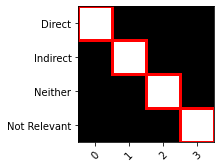

In [15]:
plot_pred_sequence(train_idxs_seq[0], split='train')

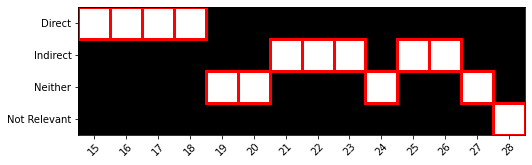

In [16]:
plot_pred_sequence(train_idxs_seq[3], split='train')

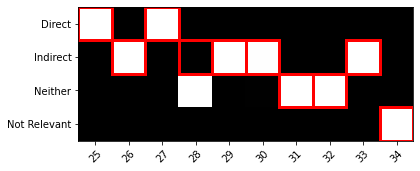

In [17]:
plot_pred_sequence(dev_idxs_seq[3], split='dev')

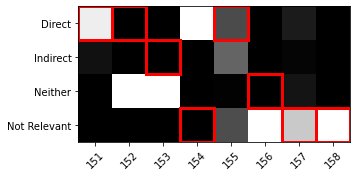

In [18]:
plot_pred_sequence(dev_idxs_seq[20], split='dev')

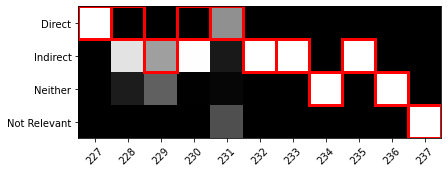

In [19]:
plot_pred_sequence(dev_idxs_seq[30], split='dev')

In [141]:
df_dev.iloc[dev_idxs_seq[30]]

,ROW ID,HADM ID,SUBJECT ID,Assessment,Plan Subsection,Relation
227,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",CORONARIES: Cath [**8-24**]: LAD w/ 3 sequenti...,Direct
228,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",PUMP: Has known ischemic cardiomyopathy with E...,Direct
229,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",RHYTHM: Paroxysmal atrial fibrillation. Sinus ...,Indirect
230,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",Hypotension: Currently on dopamine given perip...,Direct
231,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",Hypoxia: Patient intubated and sedated followi...,Direct
232,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",Anemia: Hct dropped from 30.9 pre-procedure to...,Indirect
233,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",ESRD w/ HD on MWF: Underwent normal session of...,Indirect
234,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",Gout\n -C/w allopurinol\n .,Neither
235,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...",Congenital deafness: Can read lips effectively...,Indirect
236,694761,101382,45801,"67 y/o blind, deaf male w/ESRD, s/p cath on [*...","Peptic ulcer disease, dyspepsia: Famotidine fo...",Neither


## Bayesian Inference 1. using Relative Location

### Marginal probabliity estimator

- $p(y_i)$: simple density estimator $p(y|c)$ where $c \in [0, 1]$ is the relative position in the sequence.  
We use Gaussian kernel density estimation to compute $p(c|y)$ for each $y \in \{0, 1, 2, 3\}$ and compute the marginal probability as follows:

$$ p(y|c) = \frac{p(c|y)p(y)}{\sum_{y'}p(c|y')p(y')} $$

In [16]:
# Train set
X_de = [[] for i in range(4)]

# Train examples
for idxs in train_idxs_seq:
    labels = get_label_sequence(idxs, 'train')
    for i, l in enumerate(labels):
        c = i/(len(labels)-1)  # relative position. 0 at the beginning and 1 at the end
        X_de[l].append(c)
        
# Dev examples
# for idxs in dev_idxs_seq:
#     labels = get_label_sequence(idxs, 'dev')
#     for i, l in enumerate(labels):
#         c = i/(len(labels)-1)  # relative position. 0 at the beginning and 1 at the end
#         X_de[l].append(c)

print('\n'.join([f'{i}: {len(X_de[i])} examples' for i in range(4)]))

0: 1090 examples
1: 1249 examples
2: 1484 examples
3: 810 examples


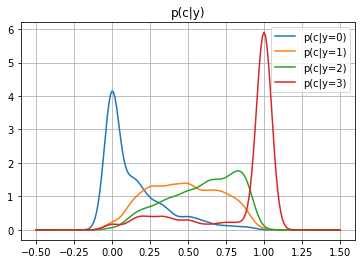

In [17]:
# Train KDE to estimate p(c|y)
train_density_estimators = []
for i in range(4):
    density_estimator = KernelDensity(kernel='gaussian', bandwidth=0.05)
    density_estimator.fit(np.array(X_de[i])[:,np.newaxis])
    train_density_estimators.append(density_estimator)
    
    X = ((np.arange(201)-50)/100).reshape(-1, 1)
    p = np.exp(density_estimator.score_samples(X))
    plt.plot(X, p, label=f'p(c|y={i})')
plt.grid()
plt.legend()
plt.title('p(c|y)');

In [18]:
# Estimate p(y|c) given the seq len
p_y = np.array(list(map(len, X_de))).astype(float)
p_y /= np.sum(p_y)

def get_p_c_y(seq_len):
    c = np.array([i/(seq_len-1) for i in range(seq_len)])[:,np.newaxis]
    p_c_y = [np.exp(train_density_estimators[i].score_samples(c)) for i in range(4)]
    return np.array(p_c_y).T

def get_p_y_c(seq_len):
    assert seq_len > 1
    p_c_y = get_p_c_y(seq_len)
    p_y_c = p_c_y * p_y
    p_y_c /= p_y_c.sum(axis=1, keepdims=True)
    return p_y_c

In [19]:
get_p_c_y(10)

array([[4.14683065, 0.23064327, 0.06701469, 0.16813472],
       [1.672396  , 0.7306809 , 0.36455776, 0.24915289],
       [1.12379648, 1.22879181, 0.65510811, 0.40952453],
       [0.74913476, 1.31002493, 0.87093374, 0.40725714],
       [0.39904851, 1.38241051, 1.06513312, 0.29570376],
       [0.3446257 , 1.24956232, 1.25433296, 0.22715523],
       [0.17979232, 1.19409312, 1.50895277, 0.18325942],
       [0.12282686, 1.03399178, 1.65421129, 0.22642947],
       [0.08731969, 0.56914493, 1.44126326, 0.6586105 ],
       [0.00880451, 0.05278634, 0.12475822, 5.90504879]])

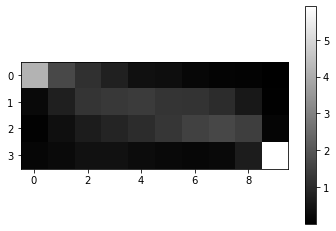

In [41]:
plt.imshow(get_p_c_y(10).transpose(), cmap='gray'); plt.colorbar();

In [42]:
get_p_y_c(10)

array([[0.89616623, 0.05711484, 0.0197174 , 0.02700152],
       [0.52407372, 0.26237168, 0.1555346 , 0.05802   ],
       [0.30144203, 0.37768557, 0.2392415 , 0.0816309 ],
       [0.20037606, 0.40151464, 0.31716   , 0.0809493 ],
       [0.10923854, 0.43363384, 0.39697348, 0.06015415],
       [0.09434043, 0.39196208, 0.46748796, 0.04620952],
       [0.04809025, 0.36598225, 0.54950157, 0.03642593],
       [0.03294652, 0.31781118, 0.60410791, 0.04513439],
       [0.02736311, 0.20436761, 0.61489927, 0.15337001],
       [0.00190273, 0.01307163, 0.036707  , 0.94831864]])

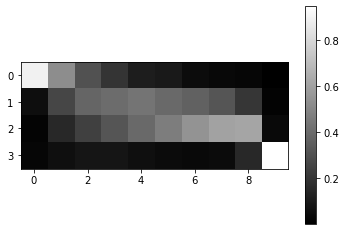

In [43]:
plt.imshow(get_p_y_c(10).transpose(), cmap='gray'); plt.colorbar();

### Position augmented posterior

Assuming $c \perp\!\!\!\perp x | y$, we can compute the posterior probability of the relation given the input text AND the relative location as
$$ p(y|x,c) = \frac{p(y,c|x)}{p(c|x)} = \frac{p(y|x)p(c|y,x)}{p(c|x)} = \frac{p(y|x)p(c|y)}{p(c|x)} = \frac{1}{\alpha} p(y|x)p(c|y) $$
where $\alpha=p(c|x)$ is normalizing the distribution over $y$.

In [20]:
# Compute p(y_i|X) from p(y_i|x_i)
def update_seq_probs_pos(seq_probs):
    seq_len = len(seq_probs)
    p_c_y = get_p_y_c(seq_len)
    final_probs = seq_probs * p_c_y
    final_probs /= final_probs.sum(axis=1, keepdims=True)
    return final_probs

def update_probs_pos(probs, split='train'):
    idxs_seq = {'train': train_idxs_seq, 'dev': dev_idxs_seq, 'test': test_idxs_seq}[split]
    updated_probs = []
    for idxs in idxs_seq:
        seq_probs = probs[idxs]
        final_probs = update_seq_probs_pos(seq_probs)
        updated_probs.append(final_probs)    
    updated_probs = np.concatenate(updated_probs, axis=0)
    return updated_probs

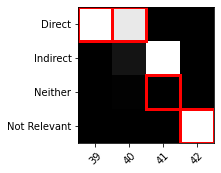

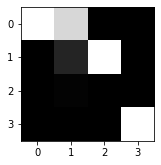

In [21]:
idx = 5
plot_pred_sequence(dev_idxs_seq[idx], 'dev')
plt.figure(figsize=(len(dev_idxs_seq[idx]) * 0.6, 3))
plt.imshow(update_seq_probs_pos(get_prob_sequence(dev_idxs_seq[idx], 'dev')).T, cmap='gray')

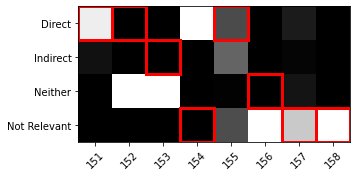

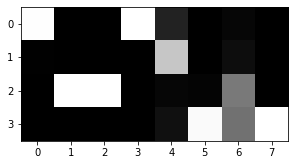

In [22]:
idx = 20
plot_pred_sequence(dev_idxs_seq[idx], 'dev')
plt.figure(figsize=(len(dev_idxs_seq[idx]) * 0.6, 3))
plt.imshow(update_seq_probs_pos(get_prob_sequence(dev_idxs_seq[idx], 'dev')).T, cmap='gray')

- Train set performance
    - Accuracy: 0.616231 (2855/4633)
    - Macro F1: 0.640417
- Dev set performance
    - Accuracy: 0.624791 (373/597)
    - Macro F1: 0.652278
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct      761      221      107        1     1090 |   Direct       99       26       20        0      145
Indirect      152      465      626        6     1249 | Indirect       23       71       84        1      179
 Neither       86      354     1030       14     1484 |  Neither       12       32      128        1      173
Not Rele       45       83       83      599      810 | Not Rele        4       11       10       75      100
Pred cnt     1044     1123     1846      620     4633 | Pred cnt      138      140      242       77      597


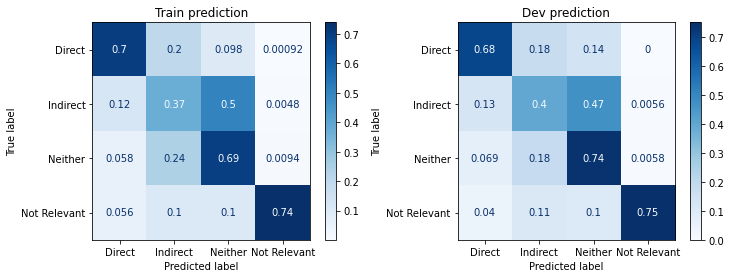

In [23]:
# When predict only with p(y|c)
train_probs = np.concatenate([get_p_y_c(len(idxs)) for idxs in train_idxs_seq], axis=0)
dev_probs = np.concatenate([get_p_y_c(len(idxs)) for idxs in dev_idxs_seq], axis=0)
train_preds = np.argmax(train_probs, axis=1)
dev_preds = np.argmax(dev_probs, axis=1)
plot_print_results(train_preds, dev_preds)

In [24]:
exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer',
]

ckpt_steps = [i * 1000 for i in range(1, 10)] + [9999]

exp_names = [
    'sent_rel_PubMedBERT_noshuffle',
    'sent_rel_PubMedBERT',
    'sent_rel_PubMedBERT_2gpu_noshuffle',
    'sent_rel_PubMedBERT_2gpu',
    'sent_rel_BioClinicalBERT_noshuffle',
    'sent_rel_BioClinicalBERT',
    'sent_rel_BioClinicalBERT_2gpu_noshuffle',
    'sent_rel_BioClinicalBERT_2gpu',
    'sent_rel_BlueBERT-Base_noshuffle',
    'sent_rel_BlueBERT-Base',
    'sent_rel_BlueBERT-Base_2gpu_noshuffle',
    'sent_rel_BlueBERT-Base_2gpu',
    'sent_rel_BlueBERT-Large_noshuffle',
    'sent_rel_BlueBERT-Large',
    'sent_rel_BlueBERT-Large_2gpu_noshuffle',
    'sent_rel_BlueBERT-Large_2gpu',
    'sent_rel_Clinical-Longformer_noshuffle',
    'sent_rel_Clinical-Longformer',
]

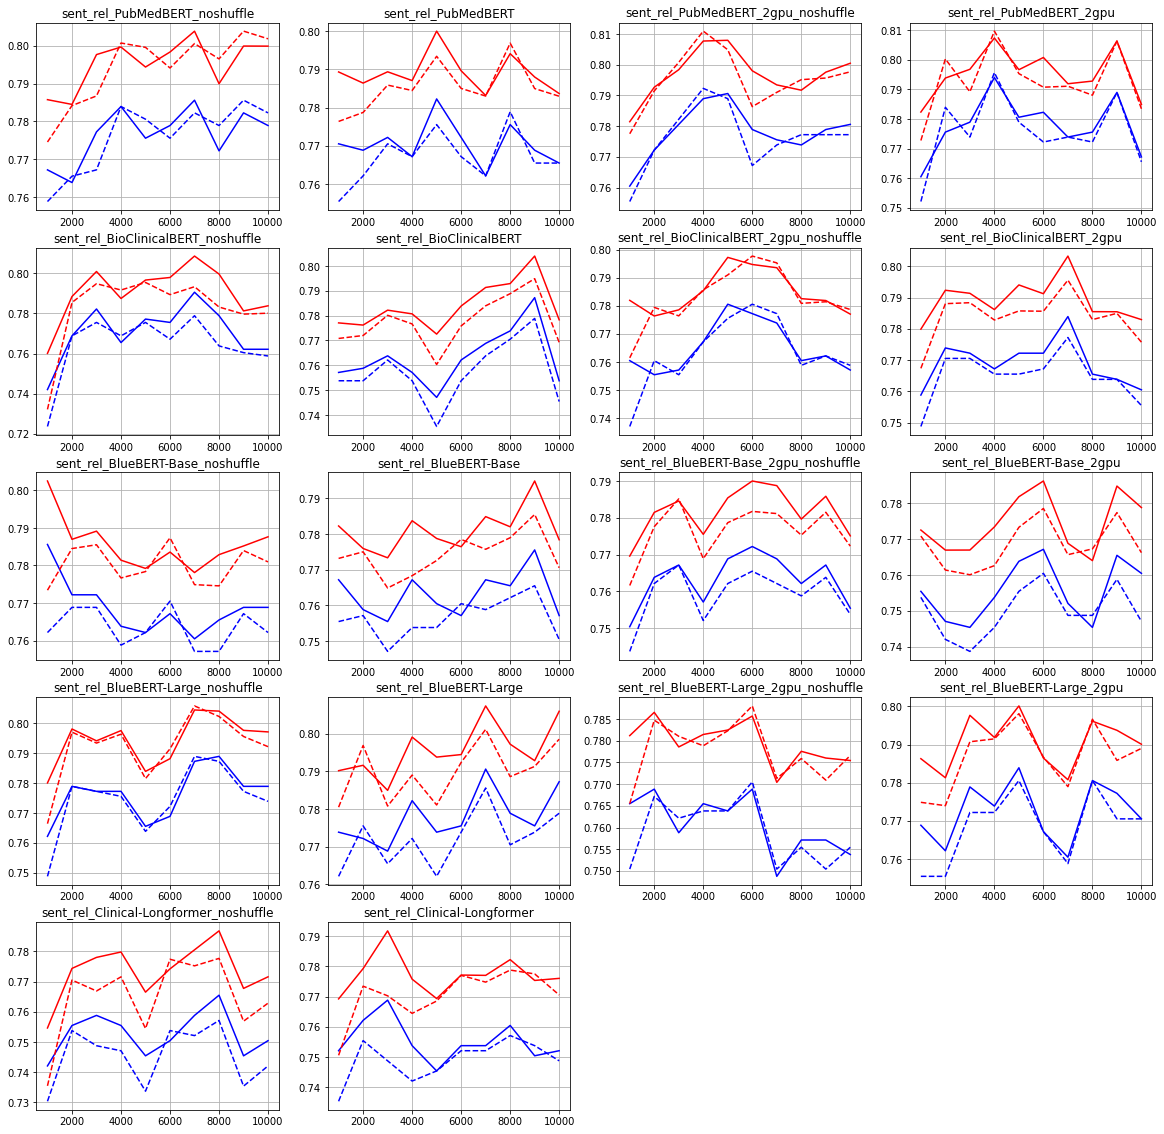

In [107]:
plt.figure(figsize=(20, 20))

for i, exp_name in enumerate(exp_names):
    results_dir = f'../results/{exp_name}'
    
    plt.subplot((len(exp_names) + 3) // 4, 4, i+1)
    dev_accs, dev_f1s = [], []
    dev_accs_updated, dev_f1s_updated = [], []

    for ckpt_step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_probs = softmax(dev_logits)
        dev_preds = np.argmax(dev_logits, axis=1)

        dev_accs.append(np.mean(dev_preds == dev_labels))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))

        dev_probs_updated = update_probs_pos(dev_probs, split='dev')
        dev_preds_updated = np.argmax(dev_probs_updated, axis=1)

        dev_accs_updated.append(np.mean(dev_preds_updated == dev_labels))
        dev_f1s_updated.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds_updated, average="macro"))
    plt.plot(ckpt_steps, dev_accs, 'b--', label='dev acc')
    plt.plot(ckpt_steps, dev_accs_updated, 'b-', label='dev acc (updated)')
    plt.plot(ckpt_steps, dev_f1s, 'r--', label='dev f1')
    plt.plot(ckpt_steps, dev_f1s_updated, 'r-', label='dev f1 (updated)')
    plt.grid()
#     plt.legend()
    plt.title(exp_name)

Ensemble of following results
	(../results/sent_rel_PubMedBERT_noshuffle/, step 7000)
	(../results/sent_rel_BioClinicalBERT_noshuffle/, step 7000)
	(../results/sent_rel_BlueBERT-Base_noshuffle/, step 1000)
	(../results/sent_rel_BlueBERT-Large_noshuffle/, step 7000)
- Train set performance
    - Accuracy: 1.000000 (4633/4633)
    - Macro F1: 1.000000
- Dev set performance
    - Accuracy: 0.797320 (476/597)
    - Macro F1: 0.815221
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      113       22        8        2      145
Indirect        0     1249        0        0     1249 | Indirect       12      127       38        2      179
 Neither        0        0     1484        0     1484 |  Neither        3       27      143        0      173
Not Rele        0        0        0      810      810 | Not Rele        2        1        4       93      100
Pred cnt     109

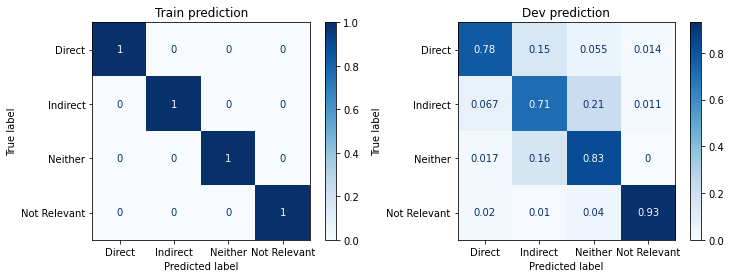

In [130]:
dir_step_list = [
    ('../results/sent_rel_PubMedBERT_noshuffle/',          7000),
#     ('../results/sent_rel_PubMedBERT/',                    5000),
    ('../results/sent_rel_BioClinicalBERT_noshuffle/',     7000),
#     ('../results/sent_rel_BioClinicalBERT/',               9000),
    ('../results/sent_rel_BlueBERT-Base_noshuffle/',       1000),
#     ('../results/sent_rel_BlueBERT-Base/',                 9000),
    ('../results/sent_rel_BlueBERT-Large_noshuffle/',      7000),
#     ('../results/sent_rel_BlueBERT-Large/',                7000),
#     ('../results/sent_rel_Clinical-Longformer_noshuffle/', 8000),
#     ('../results/sent_rel_Clinical-Longformer/',           3000),
]

plot_results_ensemble(dir_step_list, ensemble='probs')

- Train set performance
    - Accuracy: 0.993093 (4601/4633)
    - Macro F1: 0.992605
- Dev set performance
    - Accuracy: 0.798995 (477/597)
    - Macro F1: 0.815262
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1083        6        1        0     1090 |   Direct      112       25        8        0      145
Indirect        6     1242        0        1     1249 | Indirect        9      135       34        1      179
 Neither        1        0     1482        1     1484 |  Neither        1       28      144        0      173
Not Rele        2        2       12      794      810 | Not Rele        6        2        6       86      100
Pred cnt     1092     1250     1495      796     4633 | Pred cnt      128      190      192       87      597


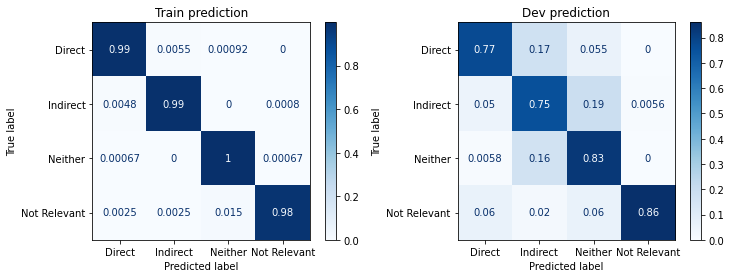

In [127]:
train_probs = get_ensemble(dir_step_list, split='train', ensemble='probs')
dev_probs = get_ensemble(dir_step_list, split='dev', ensemble='probs')
train_probs_updated = update_probs_pos(train_probs, split='train')
dev_probs_updated = update_probs_pos(dev_probs, split='dev')
train_preds_updated = np.argmax(train_probs_updated, axis=1)
dev_preds_updated = np.argmax(dev_probs_updated, axis=1)
plot_print_results(train_preds_updated, dev_preds_updated)   

- Test: performance of positional probability on dev split sets

In [97]:
seq_idxs = list(range(len(dev_idxs_seq)))
random.seed(123)
random.shuffle(seq_idxs)

dev1_idxs = [i for si in seq_idxs[:len(dev_idxs_seq)//2] for i in dev_idxs_seq[si]]
dev2_idxs = [i for si in seq_idxs[len(dev_idxs_seq)//2:] for i in dev_idxs_seq[si]]
assert len(df_dev) == len(set(dev1_idxs) | set(dev2_idxs))
print(f'Dev set {len(df_dev)} -> {len(dev1_idxs)} / {len(dev2_idxs)}')
dev1_labels = dev_labels[dev1_idxs]
dev2_labels = dev_labels[dev2_idxs]

Dev set 597 -> 295 / 302


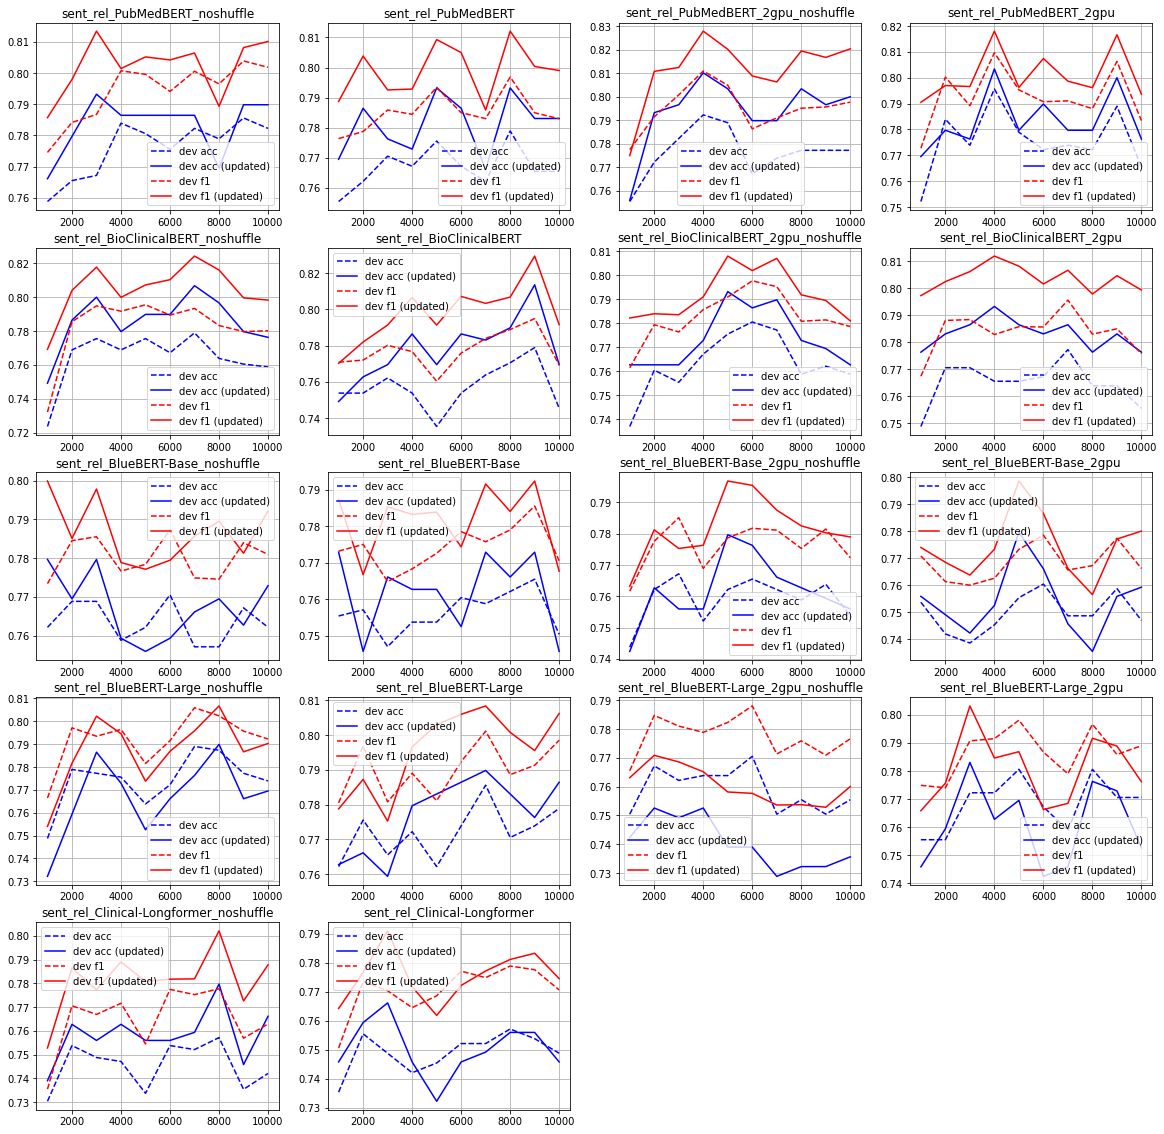

In [133]:
plt.figure(figsize=(20, 20))

for i, exp_name in enumerate(exp_names):
    results_dir = f'../results/{exp_name}'
    
    plt.subplot((len(exp_names) + 3) // 4, 4, i+1)
    dev_accs, dev_f1s = [], []
    dev_accs_updated, dev_f1s_updated = [], []

    for ckpt_step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_probs = softmax(dev_logits)
        dev_preds = np.argmax(dev_logits, axis=1)

        dev_accs.append(np.mean(dev_preds == dev_labels))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))

        dev_probs_updated = update_probs_pos(dev_probs, split='dev')
        dev_preds_updated = np.argmax(dev_probs_updated, axis=1)

        dev_accs_updated.append(np.mean(dev_preds_updated[dev1_idxs] == dev_labels[dev1_idxs]))
        dev_f1s_updated.append(sklearn.metrics.f1_score(y_true=dev_labels[dev1_idxs], y_pred=dev_preds_updated[dev1_idxs], average="macro"))
    plt.plot(ckpt_steps, dev_accs, 'b--', label='dev acc')
    plt.plot(ckpt_steps, dev_accs_updated, 'b-', label='dev acc (updated)')
    plt.plot(ckpt_steps, dev_f1s, 'r--', label='dev f1')
    plt.plot(ckpt_steps, dev_f1s_updated, 'r-', label='dev f1 (updated)')
    plt.grid()
    plt.legend()
    plt.title(exp_name)

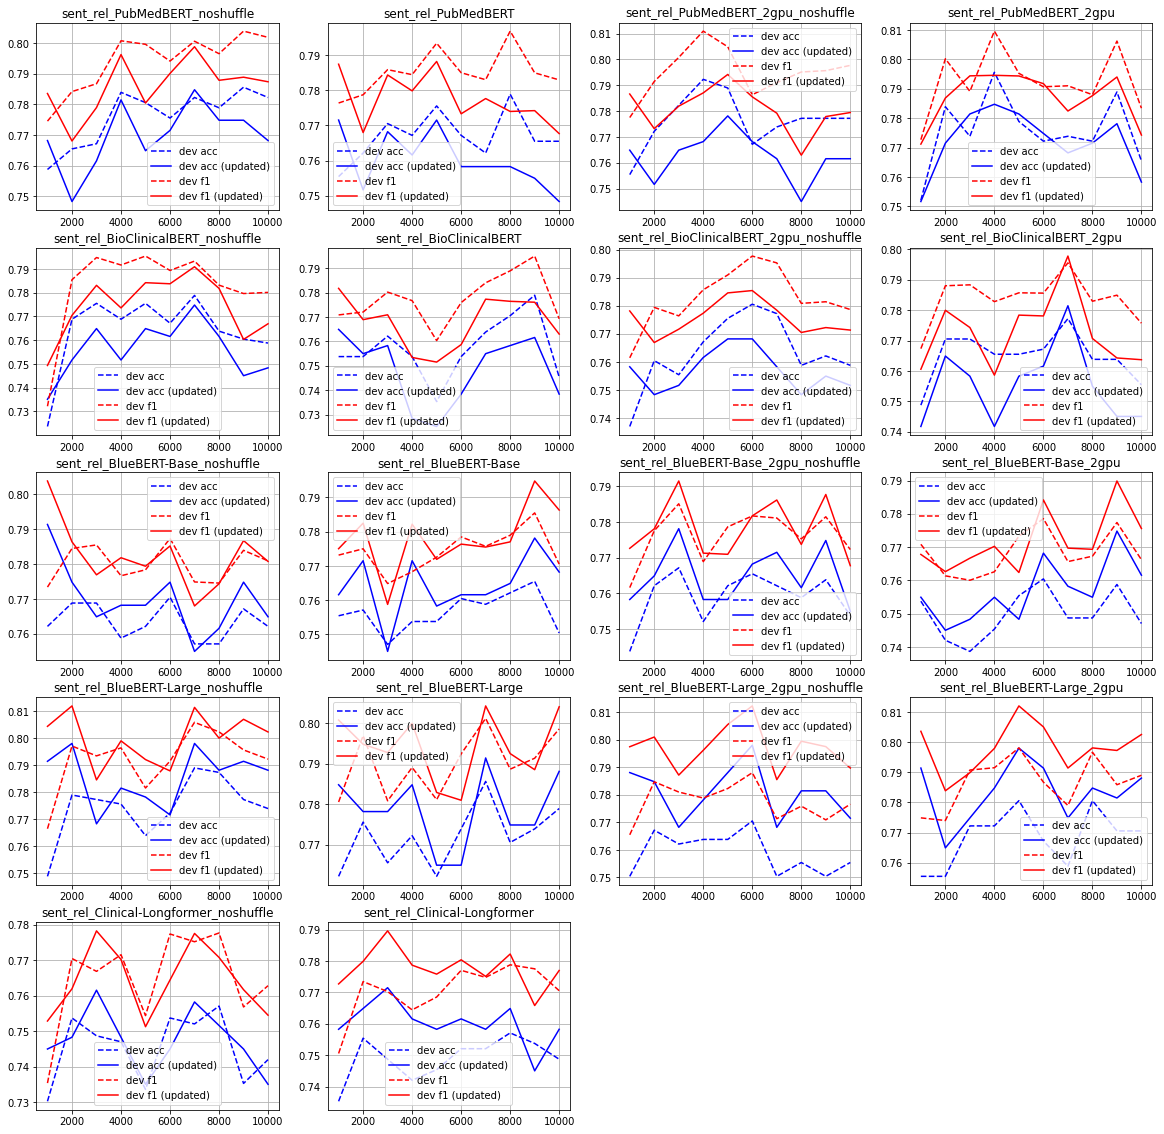

In [132]:
plt.figure(figsize=(20, 20))

for i, exp_name in enumerate(exp_names):
    results_dir = f'../results/{exp_name}'
    
    plt.subplot((len(exp_names) + 3) // 4, 4, i+1)
    dev_accs, dev_f1s = [], []
    dev_accs_updated, dev_f1s_updated = [], []

    for ckpt_step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_probs = softmax(dev_logits)
        dev_preds = np.argmax(dev_logits, axis=1)

        dev_accs.append(np.mean(dev_preds == dev_labels))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))

        dev_probs_updated = update_probs_pos(dev_probs, split='dev')
        dev_preds_updated = np.argmax(dev_probs_updated, axis=1)

        dev_accs_updated.append(np.mean(dev_preds_updated[dev2_idxs] == dev_labels[dev2_idxs]))
        dev_f1s_updated.append(sklearn.metrics.f1_score(y_true=dev_labels[dev2_idxs], y_pred=dev_preds_updated[dev2_idxs], average="macro"))
    plt.plot(ckpt_steps, dev_accs, 'b--', label='dev acc')
    plt.plot(ckpt_steps, dev_accs_updated, 'b-', label='dev acc (updated)')
    plt.plot(ckpt_steps, dev_f1s, 'r--', label='dev f1')
    plt.plot(ckpt_steps, dev_f1s_updated, 'r-', label='dev f1 (updated)')
    plt.grid()
    plt.legend()
    plt.title(exp_name)

- Save test prediction

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999601
- Dev set performance
    - Accuracy: 0.790620 (472/597)
    - Macro F1: 0.807964
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       23        7        1      145
Indirect        1     1248        0        0     1249 | Indirect       13      133       32        1      179
 Neither        0        1     1483        0     1484 |  Neither        2       33      137        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        3        4       88      100
Pred cnt     1091     1249     1483      810     4633 | Pred cnt      134      192      180       91      597


,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Direct
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Not Relevant
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Not Relevant


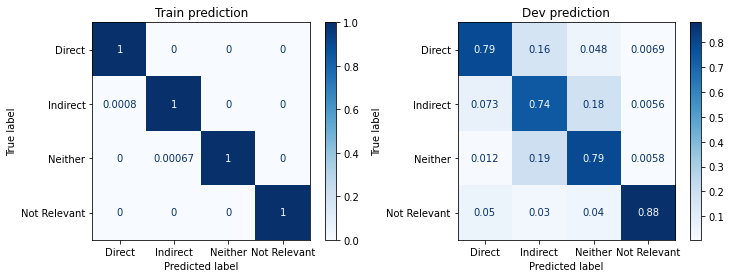

In [200]:
results_dir = '../results/sent_rel_PubMedBERT_2gpu_noshuffle/'
ckpt_step = 5000
test_output_fname = 'test_output_PubMedBERT_2gpu_noshuffle_train_5000_pos.csv'
train_results, dev_results, test_results = load_results(results_dir, ckpt_step)
train_logits = np.array([r['logits'] for r in train_results])
dev_logits = np.array([r['logits'] for r in dev_results])
test_logits = np.array([r['logits'] for r in test_results])
train_probs = softmax(train_logits)
dev_probs = softmax(dev_logits)
test_probs = softmax(test_logits)
train_probs = update_probs_pos(train_probs, split='train')
dev_probs = update_probs_pos(dev_probs, split='dev')
test_probs = update_probs_pos(test_probs, split='test')
train_preds = np.argmax(train_probs, axis=1)
dev_preds = np.argmax(dev_probs, axis=1)
test_preds = np.argmax(test_probs, axis=1)

plot_print_results(train_preds, dev_preds)

df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output

## Bayesian Inference 2. 1st-order HMM

### Markov model estimator

Here we compute transition probability $p(y_i|y_{i+1})$, the initial/last probability $p(y_0)$/$p(y_N)$, and martinal probability $p(y)$ empirically.

In [153]:
first_counts = np.zeros(4, int)
last_counts = np.zeros(4, int)
total_counts = np.zeros(4, int)
transition_counts = np.zeros((4, 4), int)

In [154]:
for idxs in train_idxs_seq:
    labels = get_label_sequence(idxs, 'train')
    first_counts[labels[0]] += 1
    for i in range(len(labels)-1):
        transition_counts[labels[i], labels[i+1]] += 1
    last_counts[labels[-1]] += 1
    for l in labels:
        total_counts[l] += 1

In [155]:
first_counts

array([550,  28,   8,  16])

In [156]:
total_counts

array([1090, 1249, 1484,  810])

In [157]:
last_counts

array([  0,   3,   1, 598])

In [158]:
transition_counts

array([[349, 370, 268, 103],
       [ 98, 485, 453, 210],
       [ 62, 312, 684, 425],
       [ 31,  54,  71,  56]])

In [166]:
# Estimator of the transition prob and the initial/final prob
p_y = total_counts / np.sum(total_counts)
p_y0 = first_counts / np.sum(first_counts)
p_yN = last_counts / np.sum(last_counts)
p_y_forward = (transition_counts / np.sum(transition_counts, axis=1, keepdims=True)).T
p_y_backward = (transition_counts / np.sum(transition_counts, axis=0, keepdims=True))

### HMM augmented posterior

Like typical HMM, we perform the forward-backward pass and find the final probability $p(y_i|x_:)$.
- Forward/backward method: recursively compute $p(y_i|x_{:i})$ from  $p(y_{i-1}|x_{:i-1})$, or vice versa.
$$p(y_i|x_{:i}) = \frac{1}{\alpha} \{\sum_{y_{i-1}} p(y_{i-1}|x_{:i-1})p(y_i|y_{i-1}) p(y_i|x_i) \frac{1}{p(y_i)} \}$$
- Final probability: compute $p(y_i|x_:)$ from the forward/backward pass results
$$p(y_i|x_:) = \frac{1}{\alpha} p(y_i|x_{:i}) \{\sum_{y_{i+1}}p(y_{i}|y_{i+1})p(y_{i+1}|x_{:i+1})\} \frac{1}{p(y_i)}$$

In [168]:
# Compute p(y_i|X) from p(y_i|x_i)
def update_seq_probs_markov(seq_probs, alpha=0.0):
    seq_len = len(seq_probs)
    p_y_c = get_p_y_c(seq_len)
    p_y_s = p_y * (1.0 - alpha) + np.ones(4) * alpha / 4.0
    p_y0_s = p_y0 * (1.0 - alpha) + np.ones(4) * alpha / 4.0
    p_yN_s = p_yN * (1.0 - alpha) + np.ones(4) * alpha / 4.0
    p_y_forward_s = p_y_forward * (1.0 - alpha) + np.ones((4, 4)) * alpha / 4.0
    p_y_backward_s = p_y_backward * (1.0 - alpha) + np.ones((4, 4)) * alpha / 4.0
    
    forward_states = []
    for i in range(seq_len):
        if i == 0:
            # Option 1
#             state = seq_probs[0]
            # Option 2
#             state = p_y_c[0] * seq_probs[0] / p_y_s
            # Option 3 -> Chosen
            state = p_y0_s * seq_probs[0] / p_y_s
            state /= state.sum()
        else:
            # Option 1 -> Chosen
            state = np.matmul(p_y_forward_s, state) * seq_probs[i] / p_y_s
            # Option 2
#             state = np.matmul(p_y_forward_s, state) * seq_probs[i] / p_y_c[i]
            state /= state.sum()
        forward_states.append(state)
        
    backward_states = []
    for i in range(seq_len-1, -1, -1):
        if i == 0:
            # Option 1
#             state = seq_probs[-1]
            # Option 2
#             state = p_y_c[-1] * seq_probs[-1] / p_y_s
            # Option 3 -> Chosen
            state = p_yN_s * seq_probs[0] / p_y_s
            state /= state.sum()
        else:
            # Option 1 -> Chosen
            state = np.matmul(p_y_backward_s, state) * seq_probs[i] / p_y_s
            # Option 2
#             state = np.matmul(p_y_backward_s, state) * seq_probs[i] / p_y_c[i]
            state /= state.sum()
        backward_states.append(state)
    backward_states.reverse()
    
    final_probs = []
    for i in range(seq_len-1):
        final_probs.append(forward_states[i] * np.matmul(p_y_backward, backward_states[i+1]) / p_y_s)
    final_probs.append(np.matmul(p_y_forward, forward_states[seq_len-2]) * backward_states[seq_len-1] / p_y_s)
#     for i in range(seq_len-1):
#         final_probs.append(forward_states[i] * np.matmul(p_y_backward, backward_states[i+1]) / p_y_c[i])
#     final_probs.append(np.matmul(p_y_forward, forward_states[seq_len-2]) * backward_states[seq_len-1] / p_y_c[-1])
    final_probs = np.array(final_probs)
    final_probs /= final_probs.sum(axis=1, keepdims=True)
    return final_probs

def update_probs_markov(probs, split='train', alpha=0.0):
    idxs_seq = {'train': train_idxs_seq, 'dev': dev_idxs_seq, 'test': test_idxs_seq}[split]
    updated_probs = []
    for idxs in idxs_seq:
        seq_probs = probs[idxs]
        final_probs = update_seq_probs_markov(seq_probs, alpha)
        updated_probs.append(final_probs)    
    updated_probs = np.concatenate(updated_probs, axis=0)
    return updated_probs

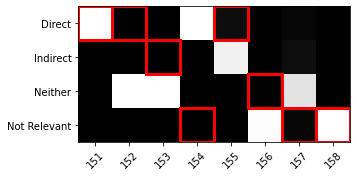

In [169]:
plot_pred_sequence(dev_idxs_seq[20], 'dev')

In [171]:
get_prob_sequence(dev_idxs_seq[20])

array([[9.99999955e-01, 4.00948531e-09, 3.91682011e-08, 2.01376569e-09],
       [5.19441810e-06, 3.83164431e-05, 9.99954286e-01, 2.20296758e-06],
       [3.91304734e-08, 5.10808371e-05, 9.99948877e-01, 2.62270057e-09],
       [1.14425054e-08, 1.22900886e-05, 9.99987695e-01, 3.19156225e-09],
       [1.97147846e-07, 2.15539120e-05, 9.99978159e-01, 9.02535217e-08],
       [2.44086999e-07, 1.49053982e-05, 9.99983877e-01, 9.73261811e-07],
       [1.00317059e-08, 4.35854269e-06, 9.99995612e-01, 1.91131588e-08],
       [3.57733521e-10, 4.02706192e-11, 2.79078976e-09, 9.99999997e-01]])

In [172]:
update_seq_probs_markov(get_prob_sequence(dev_idxs_seq[20], 'dev'))

array([[9.99988740e-01, 1.10060218e-05, 3.71925691e-08, 2.17047689e-07],
       [3.53468497e-06, 1.38709456e-04, 9.99857719e-01, 3.70480018e-08],
       [2.81232752e-05, 2.13416024e-04, 9.99746726e-01, 1.17342630e-05],
       [9.99856657e-01, 1.47243738e-05, 1.00298144e-05, 1.18589204e-04],
       [3.44591863e-02, 9.63422593e-01, 2.10115587e-03, 1.70644746e-05],
       [2.42636427e-03, 2.42734576e-03, 3.61346007e-02, 9.59011689e-01],
       [4.71228283e-03, 3.15702670e-02, 9.53089512e-01, 1.06279384e-02],
       [9.40195861e-09, 1.02075379e-09, 1.90887323e-08, 9.99999970e-01]])

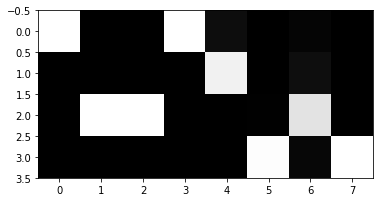

In [173]:
plt.imshow(get_prob_sequence(dev_idxs_seq[20], 'dev').T, cmap='gray')

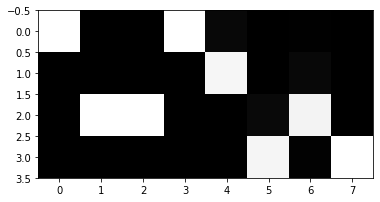

In [174]:
plt.imshow(update_seq_probs_markov(get_prob_sequence(dev_idxs_seq[20], 'dev')).T, cmap='gray')

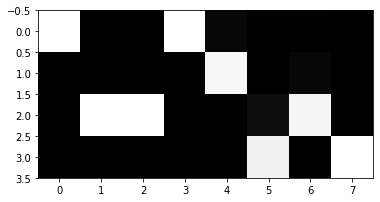

In [178]:
plt.imshow(update_seq_probs_markov(get_prob_sequence(dev_idxs_seq[20], 'dev'), alpha=0.9).T, cmap='gray')

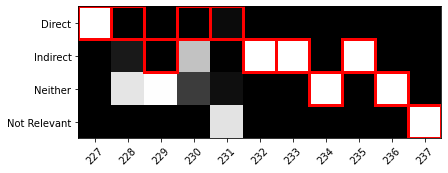

In [181]:
seq = 30
plot_pred_sequence(dev_idxs_seq[seq], 'dev')

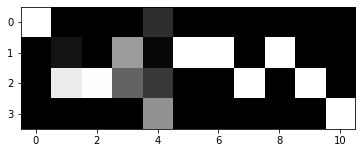

In [182]:
plt.imshow(update_seq_probs_markov(get_prob_sequence(dev_idxs_seq[seq], 'dev'), alpha=0.9).T, cmap='gray')

In [196]:
# Best single model
train_results, dev_results, test_results = load_results('../results/sent_rel_PubMedBERT_2gpu_noshuffle/', 4000)
train_logits = np.array([r['logits'] for r in train_results])
dev_logits = np.array([r['logits'] for r in dev_results])
test_logits = np.array([r['logits'] for r in test_results])
train_probs = softmax(train_logits)
dev_probs = softmax(dev_logits)
test_probs = softmax(test_logits)
train_preds = np.argmax(train_logits, axis=1)
dev_preds = np.argmax(dev_logits, axis=1)
test_preds = np.argmax(test_logits, axis=1)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.792295 (473/597)
    - Macro F1: 0.810949
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        6        1      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       29        2      179
 Neither        0        2     1482        0     1484 |  Neither        2       38      132        1      173
Not Rele        0        0        0      810      810 | Not Rele        4        2        3       91      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      132      200      170       95      597


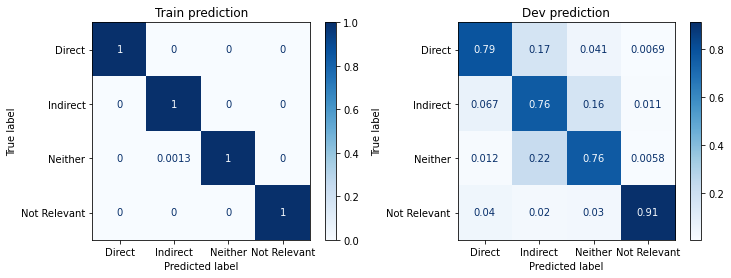

In [184]:
plot_print_results(train_preds, dev_preds)

- Train set performance
    - Accuracy: 0.999352 (4630/4633)
    - Macro F1: 0.999432
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.808765
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       30        1      179
 Neither        1        2     1481        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1091     1251     1481      810     4633 | Pred cnt      133      201      171       92      597


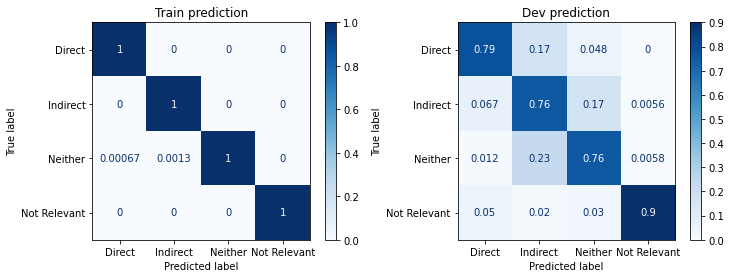

In [185]:
alpha = 0.0
updated_train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
updated_dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
updated_train_preds = np.argmax(updated_train_probs, axis=1)
updated_dev_preds = np.argmax(updated_dev_probs, axis=1)
plot_print_results(updated_train_preds, updated_dev_preds)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.808765
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       30        1      179
 Neither        0        2     1482        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      133      201      171       92      597


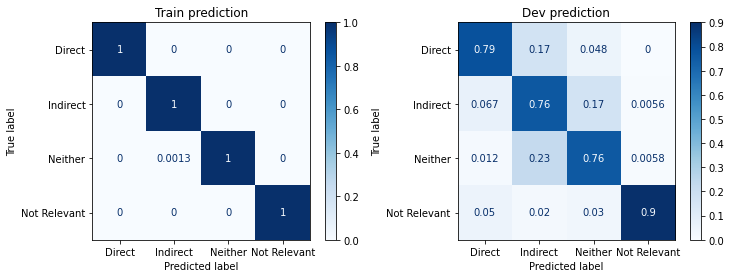

In [188]:
alpha = 0.05
updated_train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
updated_dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
updated_train_preds = np.argmax(updated_train_probs, axis=1)
updated_dev_preds = np.argmax(updated_dev_probs, axis=1)
plot_print_results(updated_train_preds, updated_dev_preds)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.808765
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       30        1      179
 Neither        0        2     1482        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      133      201      171       92      597


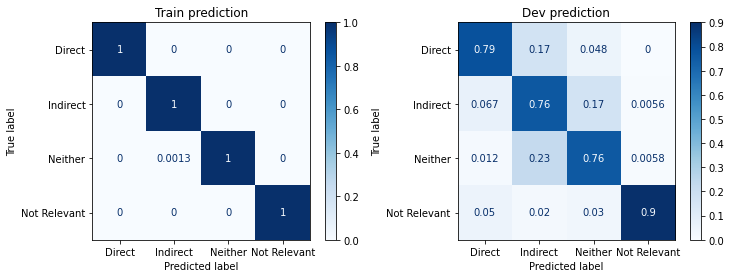

In [197]:
alpha = 0.2
updated_train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
updated_dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
updated_train_preds = np.argmax(updated_train_probs, axis=1)
updated_dev_preds = np.argmax(updated_dev_probs, axis=1)
plot_print_results(updated_train_preds, updated_dev_preds)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.808954
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       11      136       31        1      179
 Neither        0        2     1482        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      132      201      172       92      597


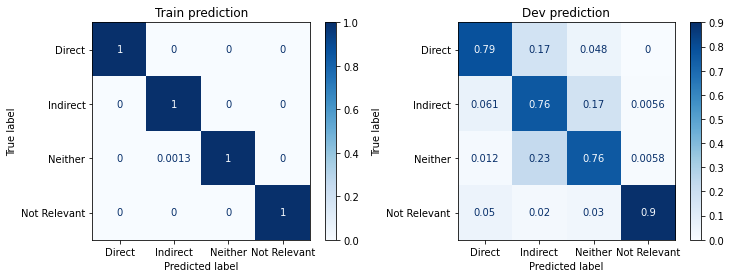

In [190]:
alpha = 0.5
updated_train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
updated_dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
updated_train_preds = np.argmax(updated_train_probs, axis=1)
updated_dev_preds = np.argmax(updated_dev_probs, axis=1)
plot_print_results(updated_train_preds, updated_dev_preds)

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.787270 (470/597)
    - Macro F1: 0.807366
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       12      135       31        1      179
 Neither        0        2     1482        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      133      200      172       92      597


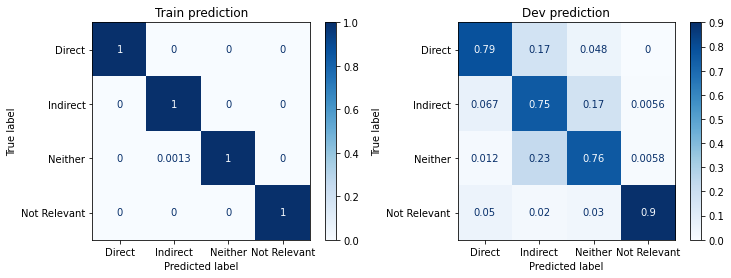

In [192]:
alpha = 1.0
updated_train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
updated_dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
updated_train_preds = np.argmax(updated_train_probs, axis=1)
updated_dev_preds = np.argmax(updated_dev_probs, axis=1)
plot_print_results(updated_train_preds, updated_dev_preds)

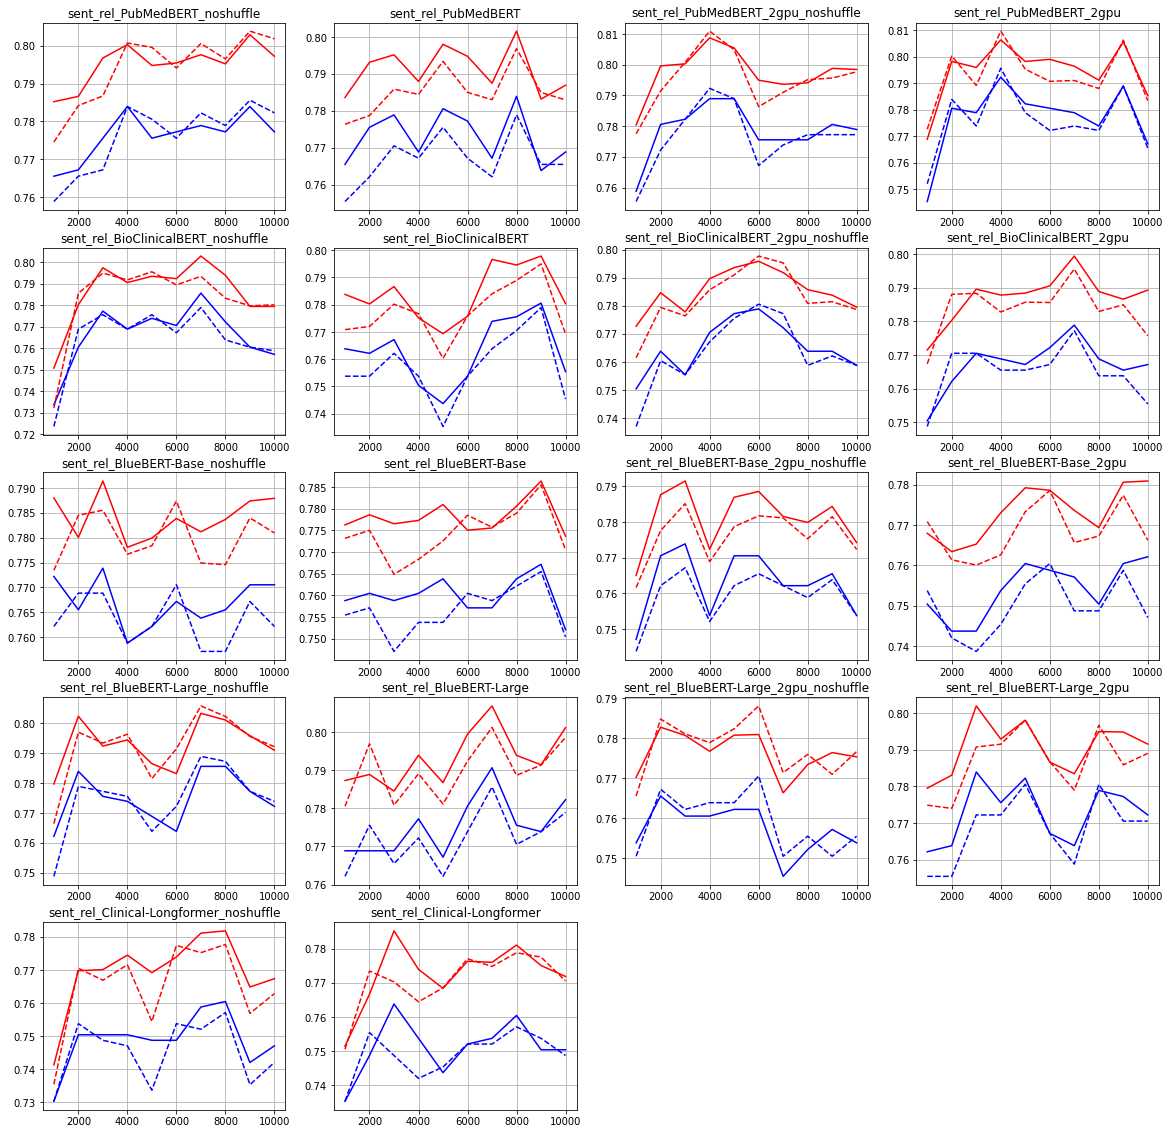

In [193]:
plt.figure(figsize=(20, 20))
alpha = 0.05

for i, exp_name in enumerate(exp_names):
    results_dir = f'../results/{exp_name}'
    
    plt.subplot((len(exp_names) + 3) // 4, 4, i+1)
    dev_accs, dev_f1s = [], []
    dev_accs_updated, dev_f1s_updated = [], []

    for ckpt_step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_probs = softmax(dev_logits)
        dev_preds = np.argmax(dev_logits, axis=1)

        dev_accs.append(np.mean(dev_preds == dev_labels))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))

        dev_probs_updated = update_probs_markov(dev_probs, split='dev', alpha=alpha)
        dev_preds_updated = np.argmax(dev_probs_updated, axis=1)

        dev_accs_updated.append(np.mean(dev_preds_updated == dev_labels))
        dev_f1s_updated.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds_updated, average="macro"))
    plt.plot(ckpt_steps, dev_accs, 'b--', label='dev acc')
    plt.plot(ckpt_steps, dev_accs_updated, 'b-', label='dev acc (updated)')
    plt.plot(ckpt_steps, dev_f1s, 'r--', label='dev f1')
    plt.plot(ckpt_steps, dev_f1s_updated, 'r-', label='dev f1 (updated)')
    plt.grid()
#     plt.legend()
    plt.title(exp_name)

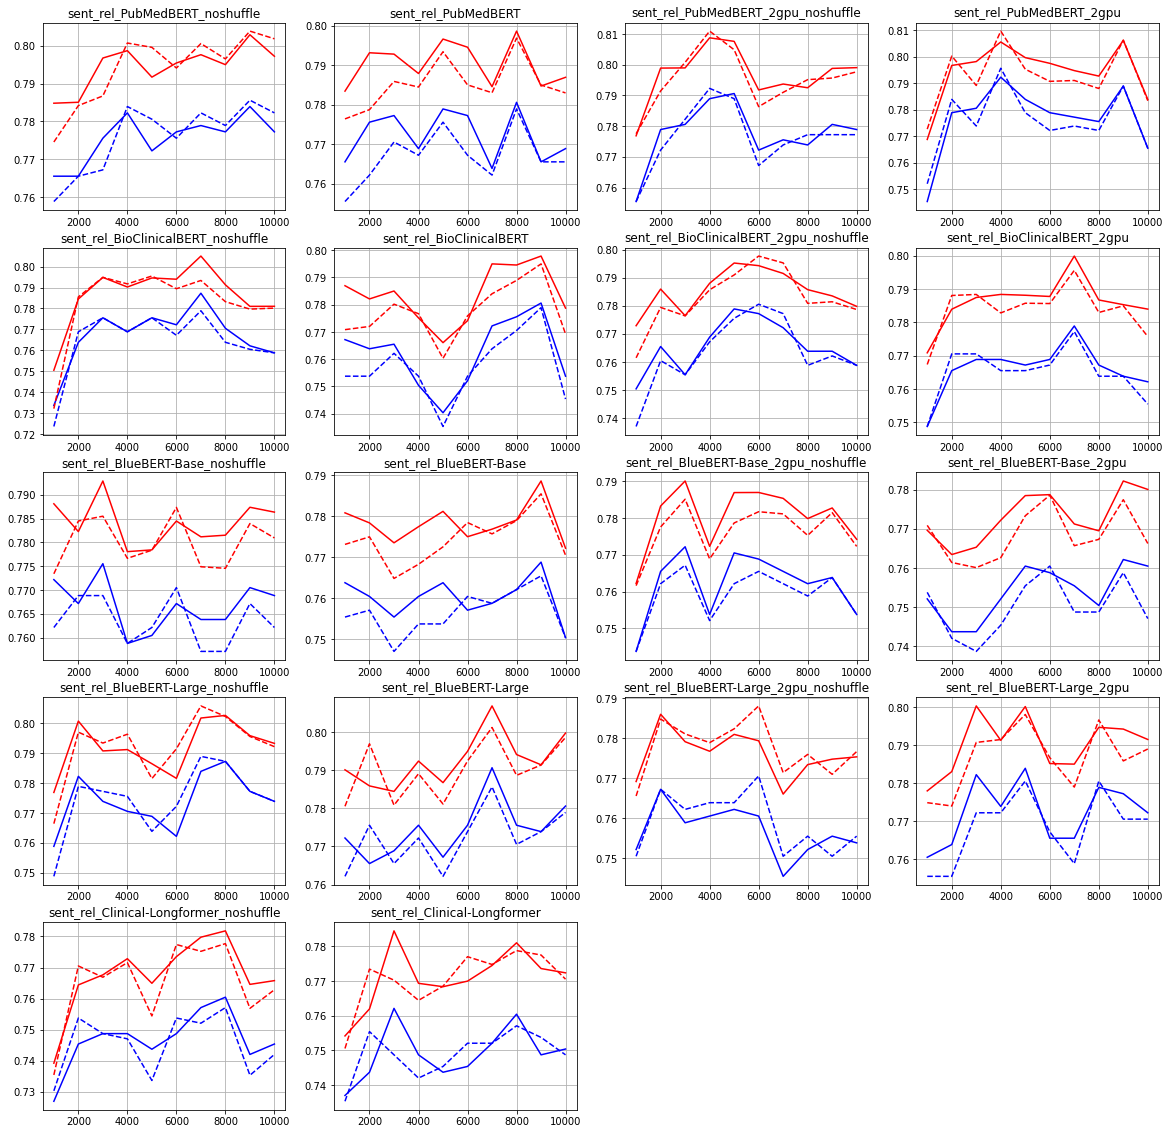

In [194]:
plt.figure(figsize=(20, 20))
alpha = 0.2

for i, exp_name in enumerate(exp_names):
    results_dir = f'../results/{exp_name}'
    
    plt.subplot((len(exp_names) + 3) // 4, 4, i+1)
    dev_accs, dev_f1s = [], []
    dev_accs_updated, dev_f1s_updated = [], []

    for ckpt_step in ckpt_steps:
        with open(os.path.join(results_dir, f'results_dev_{ckpt_step}.pkl'), 'rb') as fd:
            dev_results = pickle.load(fd)
        dev_logits = np.array([r['logits'] for r in dev_results])
        dev_probs = softmax(dev_logits)
        dev_preds = np.argmax(dev_logits, axis=1)

        dev_accs.append(np.mean(dev_preds == dev_labels))
        dev_f1s.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds, average="macro"))

        dev_probs_updated = update_probs_markov(dev_probs, split='dev', alpha=alpha)
        dev_preds_updated = np.argmax(dev_probs_updated, axis=1)

        dev_accs_updated.append(np.mean(dev_preds_updated == dev_labels))
        dev_f1s_updated.append(sklearn.metrics.f1_score(y_true=dev_labels, y_pred=dev_preds_updated, average="macro"))
    plt.plot(ckpt_steps, dev_accs, 'b--', label='dev acc')
    plt.plot(ckpt_steps, dev_accs_updated, 'b-', label='dev acc (updated)')
    plt.plot(ckpt_steps, dev_f1s, 'r--', label='dev f1')
    plt.plot(ckpt_steps, dev_f1s_updated, 'r-', label='dev f1 (updated)')
    plt.grid()
#     plt.legend()
    plt.title(exp_name)

- Save test prediction

- Train set performance
    - Accuracy: 0.999568 (4631/4633)
    - Macro F1: 0.999631
- Dev set performance
    - Accuracy: 0.788945 (471/597)
    - Macro F1: 0.808765
TRAIN      Direct Indirect  Neither Not Rele  Lbl cnt | DEV        Direct Indirect  Neither Not Rele  Lbl cnt
  Direct     1090        0        0        0     1090 |   Direct      114       24        7        0      145
Indirect        0     1249        0        0     1249 | Indirect       12      136       30        1      179
 Neither        0        2     1482        0     1484 |  Neither        2       39      131        1      173
Not Rele        0        0        0      810      810 | Not Rele        5        2        3       90      100
Pred cnt     1090     1251     1482      810     4633 | Pred cnt      133      201      171       92      597


,ROW ID,HADM ID,Assessment,Plan Subsection,Relation
0,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Sepsis\n likely has sepsis physiology with hyp...,Direct
1,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,Anuria- Renal consulted for anuria- consideri...,Indirect
2,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,R pleural effusion: Unilateral nature in the s...,Indirect
3,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,DM/hypoglycemia: possibly from not clearing me...,Direct
4,560683,106899,Ms. [**Known lastname 3847**] is a 79F with a ...,S/p recent femur fracture: held SQH overnight,Neither
...,...,...,...,...,...
662,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",5) HTN: Cont lisinopril,Neither
663,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...",6) CRI: Last Cr 1.2: Hold naproxen given...,Not Relevant
664,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","7) Nausea: likely chemo SE, cont compazi...",Neither
665,560683,196558,"DEEP VENOUS THROMBOSIS (DVT), UPPER EXTREMITY\...","8) Hyperglycemia: trend, consider HISS",Neither


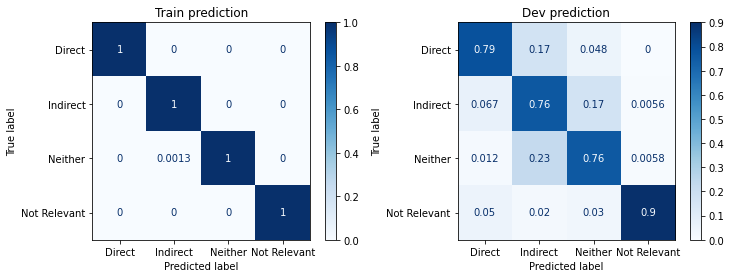

In [201]:
results_dir = '../results/sent_rel_PubMedBERT_2gpu_noshuffle/'
ckpt_step = 4000
alpha = 0.2
test_output_fname = 'test_output_PubMedBERT_2gpu_noshuffle_train_4000_mkv.csv'
train_results, dev_results, test_results = load_results(results_dir, ckpt_step)
train_logits = np.array([r['logits'] for r in train_results])
dev_logits = np.array([r['logits'] for r in dev_results])
test_logits = np.array([r['logits'] for r in test_results])
train_probs = softmax(train_logits)
dev_probs = softmax(dev_logits)
test_probs = softmax(test_logits)
train_probs = update_probs_markov(train_probs, split='train', alpha=alpha)
dev_probs = update_probs_markov(dev_probs, split='dev', alpha=alpha)
test_probs = update_probs_markov(test_probs, split='test', alpha=alpha)
train_preds = np.argmax(train_probs, axis=1)
dev_preds = np.argmax(dev_probs, axis=1)
test_preds = np.argmax(test_probs, axis=1)

plot_print_results(train_preds, dev_preds)

df_test_output = get_test_prediction_df(test_preds)
df_test_output.to_csv(os.path.join(test_output_dir, test_output_fname), index=False)
df_test_output